In [2]:
import random
import copy
import numpy as np
import pandas as pd
from scipy.spatial import distance

from Scripts import OrderedCategorySystem as OCS
from Scripts import generate_plots as plots
from Scripts import order_analyses as analyses



## Setup

In [3]:
random.seed(13)

F =  [12, 13, 15, 14, 16, 18, 17, 19, 20]
B =  [20, 19, 17, 18, 16, 14, 15, 13, 12]
M1 =  [16, 17, 15, 18, 14, 19, 13, 20, 12]
M2 = [16, 15, 17, 14, 18, 13, 19, 12, 20]

NEW = [i for i in range(9, 24)]
ALL = NEW + [1, 3, 29, 31]

SHIFT = 3
DISTRACTORS = [1, 3, 29, 31]

conditions = {1: "2LF", 2: "2LM", 3: "2LB", 4: "2CF", 5: "2CM", 6: "2CB", 7: "2RF", 8: "2RM",
              9: "2RB", 10: "3LF", 11: "3LM", 12: "3LB", 13: "3CF", 14: "3CM", 15: "3CB", 16: "3RF",
              17: "3RM", 18: "3RB", 19: "2LA", 20: "2CA", 21: "2RA", 22: "3LA", 23: "3CA", 24: "3RA"}

N = 10800

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]


with open('Stimuli/set1.txt', 'r') as f:
    set1 = [float(it) for it in f.read().split('\n')[:-1]]

with open('Stimuli/set2.txt', 'r') as f:
    set2 = [float(it) for it in f.read().split('\n')[:-1]]

with open('Stimuli/set3.txt', 'r') as f:
    set3 = [float(it)/14.85 for it in f.read().split('\n')[:-1]]

with open('Stimuli/set4.txt', 'r') as f:
    set4 = [float(it) for it in f.read().split('\n')[:-1]]

SETS = [set1, set2, set3, set4]

## Functions

In [4]:
def get_item_set(order, loc):
    if order in ['F', 'B', 'M']: # Sequence
        if order == 'F':
            items = F
        elif order == 'B':
            items = B
        else: 
            items = random.choice([M1, M2])
        random.shuffle(DISTRACTORS)
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        return items[0:1] + DISTRACTORS[0:1] + items[1:4] + DISTRACTORS[1:2] + items[4:5] + DISTRACTORS[2:3] + items[5:8] + DISTRACTORS[3:4] + items[8:9]
    else: # All at once 
        items = F
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        final_set = items + DISTRACTORS
        random.shuffle(final_set)
        return final_set

def simulate_trials(conditions, n, softmax, temp=1, noise=0):
    trials = []
    for i in range(n):
        cond = (i % 24) + 1
        code = conditions[cond]
        d, l, o = list(code)
        items = get_item_set(o, l)
        s_idx = random.choice(range(len(SETS)))
        stimuli = SETS[s_idx]
        extremes = [stimuli[0], stimuli[-1]]
        extremes.sort()
        D, item_hash = OCS.get_distance_mat(stimuli[1:-1], extremes[0], extremes[1], noise)
        if d == '2':
            syst = OCS.CategorySystem(item_hash, '..\\Katie2025_AlienTaxonomist\\static_98863bd139ec98cf6bc52549beaaf679\\taxonomies\\tree2D.json')
        else:
            syst = OCS.CategorySystem(item_hash, '..\\Katie2025_AlienTaxonomist\\static_98863bd139ec98cf6bc52549beaaf679\\taxonomies\\tree3D.json')
        if softmax:
            _, cat_choices = OCS.greedy_categorizer_softmax(syst, items, D, temp)
        else:
            _, cat_choices = OCS.greedy_categorizer(syst, items, D)
        cat_choices['DEPTH'] = int(d)
        cat_choices['LOC'] = l
        cat_choices['ORDER'] = o.lower()
        cat_choices['P_ID'] = f'{i:05d}'
        cat_choices['POOL'] = 'sim'
        cat_choices['STIMULI'] = s_idx+1
        trials.append(cat_choices)
        if i % 1000 == 1:
            print(f'{i} iteration(s) completed')
    df = pd.DataFrame.from_dict(trials)
    df = df[['P_ID', 'DEPTH', 'LOC', 'ORDER'] + [i for i in range(9, 24)] + [1, 3, 29, 31] + ['STIMULI', 'POOL']]
    df.rename(columns={i:f'I{i:02}' for i in range(9, 24)}, inplace=True)
    df.rename(columns={1: 'I01', 3: 'I03', 29: 'I29', 31: 'I31'}, inplace=True)
    return df

## Simulations
### Deterministic

1 iteration(s) completed
1001 iteration(s) completed
2001 iteration(s) completed
3001 iteration(s) completed
4001 iteration(s) completed
5001 iteration(s) completed
6001 iteration(s) completed
7001 iteration(s) completed
8001 iteration(s) completed
9001 iteration(s) completed
10001 iteration(s) completed


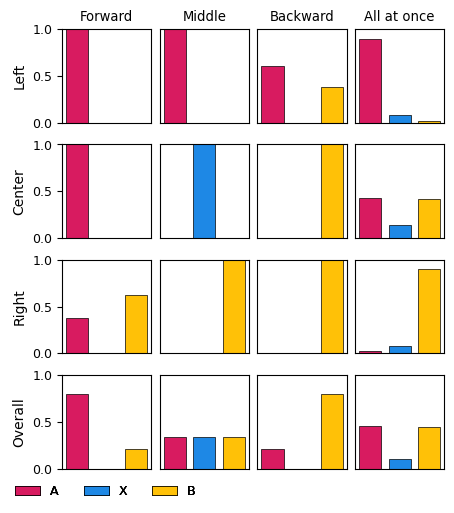

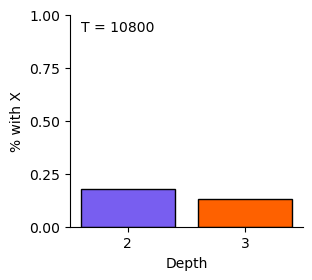

In [4]:
df_determ = simulate_trials(conditions, N, False)
df_determ = analyses.get_level2_cat_stats(df_determ, ITEMS)
plots.order_effects_plot(df_determ, fname='Figures/simulated_AXB_by_order_loc', legend=True, trials=False, figsize=(4.4, 4.75))
plots.new_category_plot(df_determ, fname='Figures/simulated_X_by_depth',  figsize=(3, 2.75))

In [5]:
seq_df = analyses.get_seq_data(df_determ, LOCS, ORDERS)
mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'Percentage of trials where all are added to the same category: {round(all_same*100, 1)}%')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob*8}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

Percentage of trials where all are added to the same category: 77.8%
Mean: 0.846
Median items: 8.0
Mode: 1.0


In [6]:
left_f, left_m, left_b =  analyses.get_jsds(df_determ, 'L')
right_f, right_m, right_b =  analyses.get_jsds(df_determ, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [left_f, right_f],
        'Middle': [left_m, right_m],
        'Backward': [left_b, right_b]})

print(table.to_string(index=False))

       Forward   Middle  Backward
 Left 0.196848 0.196848   0.37235
Right 0.365279 0.190880   0.19088


### Softmax

In [ ]:
df_sm = simulate_trials(conditions, N, True)
df_sm= analyses.get_level2_cat_stats(df_sm, ITEMS)
plots.order_effects_plot(df_sm, fname='Figures/simulated_softmax_AXB_by_order_loc', legend=True, trials=False, figsize=(4.4, 4.75))
plots.new_category_plot(df_sm, fname='Figures/simulated_softmax_X_by_depth',  figsize=(3, 2.75))
df_hyp3 = df_sm[['DEPTH', 'HAS_X']].groupby(['DEPTH']).mean().reset_index()
avg = df_hyp3['HAS_X'].values
print(avg[0] - avg[1])

1 iteration(s) completed


In [ ]:
seq_df = analyses.get_seq_data(df_sm, LOCS, ORDERS)
mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'Percentage of trials where all are added to the same category: {round(all_same*100, 1)}%')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob*8}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

Percentage of trials where all are added to the same category: 62.6%
Mean: 0.805
Median items: 8.0
Mode: 1.0


In [9]:
left_f, left_m, left_b =  analyses.get_jsds(df_sm, 'L')
right_f, right_m, right_b =  analyses.get_jsds(df_sm, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [left_f, right_f],
        'Middle': [left_m, right_m],
        'Backward': [left_b, right_b]})

print(table.to_string(index=False))

       Forward   Middle  Backward
 Left 0.226520 0.156599  0.261047
Right 0.261963 0.153065  0.222699


### Softmax with noise

1 iteration(s) completed
1001 iteration(s) completed
2001 iteration(s) completed
3001 iteration(s) completed
4001 iteration(s) completed
5001 iteration(s) completed
6001 iteration(s) completed
7001 iteration(s) completed
8001 iteration(s) completed
9001 iteration(s) completed
10001 iteration(s) completed


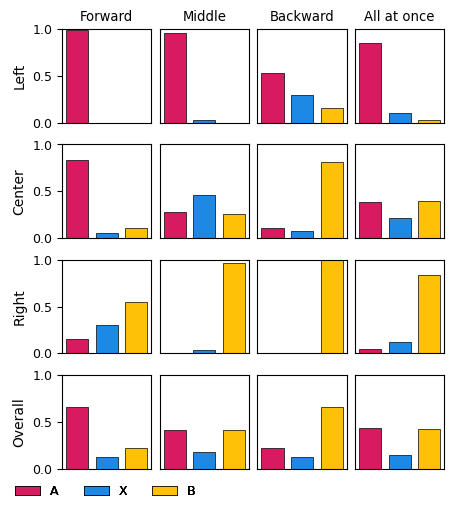

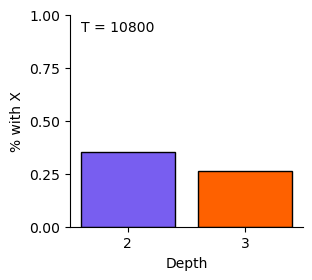

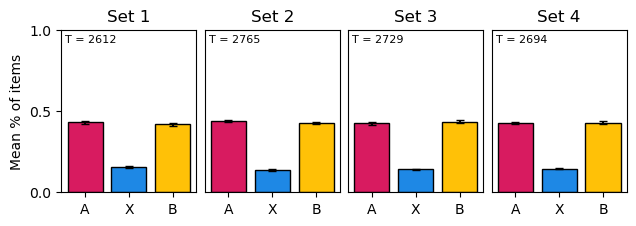

In [10]:
df_sm_noise = simulate_trials(conditions, N, True, noise=0.1)
df_sm_noise = analyses.get_level2_cat_stats(df_sm_noise, ITEMS)
plots.order_effects_plot(df_sm_noise, fname='Figures/simulated_noisy_softmax_AXB_by_order_loc', legend=True, trials=False, figsize=(4.4, 4.75))
plots.new_category_plot(df_sm_noise, fname='Figures/simulated_noisy_softmax_X_by_depth',  figsize=(3, 2.75))

plots.generate_summary_AXB_plot(df_sm_noise, 'STIMULI', [1, 2, 3, 4], ['Set 1', 'Set 2', 'Set 3', 'Set 4'], fname='Figures/simulated_noisy_sm_AXB_by_set')

In [11]:
seq_df = analyses.get_seq_data(df_sm_noise, LOCS, ORDERS)
mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'Percentage of trials where all are added to the same category: {round(all_same*100, 1)}%')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob*8}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

Percentage of trials where all are added to the same category: 55.2%
Mean: 0.782
Median items: 8.0
Mode: 1.0


In [13]:
left_f, left_m, left_b =  analyses.get_jsds(df_sm_noise, 'L')
right_f, right_m, right_b =  analyses.get_jsds(df_sm_noise, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [left_f, right_f],
        'Middle': [left_m, right_m],
        'Backward': [left_b, right_b]})

print(table.to_string(index=False))

       Forward   Middle  Backward
 Left 0.208032 0.145922  0.251931
Right 0.222799 0.167631  0.228860
